In [49]:
!pip install tensorflow==2.12
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, InputLayer,MultiHeadAttention, LayerNormalization,Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,root_mean_squared_error
from sklearn.linear_model import Ridge
!pip install keras-tcn --upgrade
from tcn import TCN  # Temporal Convolutional Network layer

In [50]:
# Load dataset
df = pd.read_csv('https://raw.githubusercontent.com/johan-naizu/dataset/refs/heads/main/dataset4.csv')
df = df.set_index('timestamp_utc')
df = df.rename_axis('DateTime')
df.index = pd.to_datetime(df.index)
df['Seconds'] = df.index.map(pd.Timestamp.timestamp)

# Add temporal features
day = 60 * 60 * 24
year = 365.2425 * day
df['Day sin'] = np.sin(df['Seconds'] * (2 * np.pi / day))
df['Day cos'] = np.cos(df['Seconds'] * (2 * np.pi / day))
df['Year sin'] = np.sin(df['Seconds'] * (2 * np.pi / year))
df['Year cos'] = np.cos(df['Seconds'] * (2 * np.pi / year))
df = df.drop('Seconds', axis=1)

# Feature selection
features = df[['temp', 'cloud_cover', 'shortwave_flux', 'power', 'Day sin', 'Day cos', 'Year sin', 'Year cos']]
target = df[['power']]

# Scaling
features_scaler = MinMaxScaler()
features_scaled = features_scaler.fit_transform(features)
target_scaler = MinMaxScaler()
target_scaled = target_scaler.fit_transform(target)

# Reshape data into sequences
def reshape_to_sequences(features, target, time_steps,horizon):
    X, y = [], []
    for i in range(features.shape[0] - time_steps - horizon + 1):
        X.append(features[i:i+time_steps])
        y.append(target[i+time_steps:i+time_steps+horizon])
    return np.array(X), np.array(y)

time_steps = 12
horizon=1
X, y = reshape_to_sequences(features_scaled, target_scaled, time_steps,horizon)

# Train-test split
train_size = int(0.8 * X.shape[0])
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
ensemble_size=int(0.8 * X_train.shape[0])
X_train, X_ensemble = X_train[:ensemble_size], X_train[ensemble_size:]
y_train, y_ensemble = y_train[:ensemble_size], y_train[ensemble_size:]
# TCN model
def create_tcn_model(input_shape):
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    model.add(TCN(nb_filters=64, kernel_size=3, dilations=[1, 2, 4, 8], dropout_rate=0.2))

    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01))) #l2 regularization added
    model.add(Dropout(0.3))
    model.add(Dense(horizon, kernel_regularizer=l2(0.01)))  # Single output for regression

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=[RootMeanSquaredError()]
    )
    return model

In [51]:

# Transformer Block
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim)  # Ensure this matches embed_dim
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)  # Self-attention
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # Residual connection
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)  # Final residual connection


# Transformer Model
def create_transformer_model(input_shape, num_heads=4, ff_dim=128, dropout_rate=0.1):
    embed_dim = input_shape[1]  # Ensure embed_dim matches input features (8)

    inputs = Input(shape=input_shape)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate)
    x = transformer_block(inputs)
    x = Flatten()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.3)(x)
    outputs = Dense(horizon)(x)  # Predict multiple time steps

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="mse",
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    return model

In [52]:
# Create and summarize the model
input_shape = (X_train.shape[1], X_train.shape[2])
tcn_model = create_tcn_model(input_shape)
tcn_model.summary()

# Callbacks
checkpoint = ModelCheckpoint('tcn_model.h5', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# Train the model
tcn_history = tcn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_1 (TCN)                 (None, 64)                88640     
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 97,089
Trainable params: 97,089
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
534/534 [==============================] - 21s 33ms/step - loss: 0.6357 - root_mean_squared_error: 0.3071 - val_loss: 0.3218 - val_root_mean_squared_error: 0.0937 - lr: 0

In [53]:
input_shape = (X_train.shape[1], X_train.shape[2])
transformer_model = create_transformer_model(input_shape)
transformer_model.summary()


# Train the model
transformer_history = transformer_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[
        ModelCheckpoint('transformer_model.h5', save_best_only=True, monitor='val_loss', mode='min'),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
    ]
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 12, 8)]           0         
                                                                 
 transformer_block_1 (Transf  (None, 12, 8)            3344      
 ormerBlock)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 96)                0         
                                                                 
 dense_10 (Dense)            (None, 128)               12416     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                           

In [54]:
# Get meta-learner training features (predictions from base models)
tcn_meta_preds = tcn_model.predict(X_ensemble)
transformer_meta_preds = transformer_model.predict(X_ensemble)

tcn_meta_preds = tcn_meta_preds.reshape(-1, 1)
transformer_meta_preds = transformer_meta_preds.reshape(-1, 1)

X_meta_train = np.concatenate([tcn_meta_preds, transformer_meta_preds], axis=1)
y_meta_train=y_ensemble
y_meta_train = y_meta_train.reshape(-1, 1)

134/134 [==============================] - 0s 2ms/step


In [55]:
class ReLUWrappedRegressor:
    def __init__(self, base_model):
        self.base_model = base_model

    def fit(self, X, y):
        self.base_model.fit(X, y)

    def predict(self, X):
        preds = self.base_model.predict(X)
        return np.maximum(preds, 0)


In [56]:
meta_model = ReLUWrappedRegressor(Ridge())
meta_model.fit(X_meta_train, y_meta_train)



In [57]:
# Get test set predictions from base models
tcn_test_preds = tcn_model.predict(X_test)
transformer_test_preds = transformer_model.predict(X_test)

tcn_test_preds = tcn_test_preds.reshape(-1, 1)
transformer_test_preds = transformer_test_preds.reshape(-1, 1)

# Combine predictions
X_meta_test = np.concatenate([tcn_test_preds, transformer_test_preds], axis=1)

# Predict using trained meta-models
ensemble_preds = meta_model.predict(X_meta_test)


167/167 [==============================] - 0s 3ms/step


In [58]:
#Test data
y_test_new = np.array(y_test).reshape(y_test.shape[0], y_test.shape[1])

test_predictions = ensemble_preds.flatten()
test_predictions = target_scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()
test_actuals = target_scaler.inverse_transform(y_test_new.reshape(-1, 1)).flatten()
test_results=pd.DataFrame(data={'Predictions':test_predictions,'Actuals':test_actuals})
test_results

,Predictions,Actuals
0,0.266764,0.00000
1,57.443066,0.00000
2,215.092484,0.46644
3,725.067261,162.74074
4,954.125000,736.85357
...,...,...
5333,10457.909180,10423.68080
5334,11736.624023,11906.68229
5335,12439.181641,12506.71949
5336,12305.059570,12351.23189


In [59]:
print(test_results.shape)


(5338, 2)


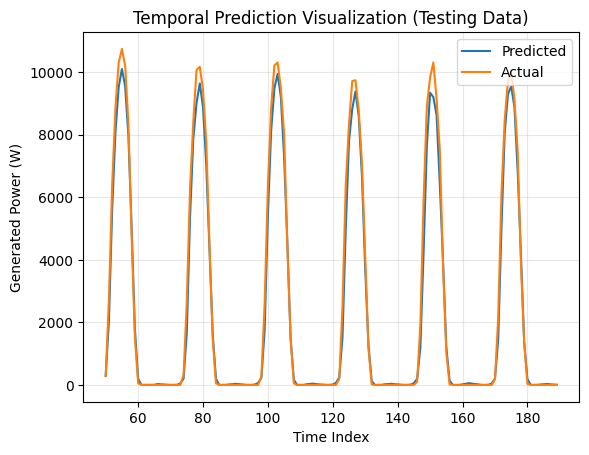

In [74]:
plt.plot(test_results['Predictions'][50:190],label='Predicted')
plt.plot(test_results['Actuals'][50:190],label='Actual')
plt.grid(alpha=0.3)
plt.legend()
plt.xlabel('Time Index')
plt.ylabel('Generated Power (W)')
plt.title("Temporal Prediction Visualization (Testing Data)")
plt.show()

In [76]:
rmse_test = np.sqrt(mean_squared_error(test_results['Predictions'], test_results['Actuals']))
mae_test = mean_absolute_error(test_results['Actuals'],test_results['Predictions'])
mse_test = mean_squared_error(test_results['Actuals'],test_results['Predictions'])
r2_test = r2_score(test_results['Actuals'],test_results['Predictions'])

In [77]:
print("Mean Absolute Error = ", mae_test)
print("Mean Squared Error = ", mse_test)
print("Root Mean Squared Error =", rmse_test)
print("r2 Score =", r2_test)

Mean Absolute Error =  396.54811603234265
Mean Squared Error =  758602.7546374596
Root Mean Squared Error = 870.9780448653454
r2 Score = 0.9448273927116801


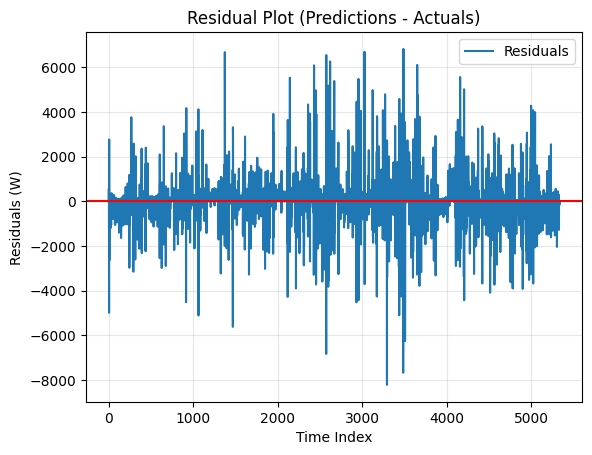

In [63]:
residual_test=pd.DataFrame(data={'Residuals':test_results['Predictions']-test_results['Actuals']})
plt.plot(residual_test['Residuals'],label='Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.grid(alpha=0.3)
plt.legend()
plt.xlabel('Time Index')
plt.ylabel('Residuals (W)')
plt.title("Residual Plot (Predictions - Actuals)")
plt.show()


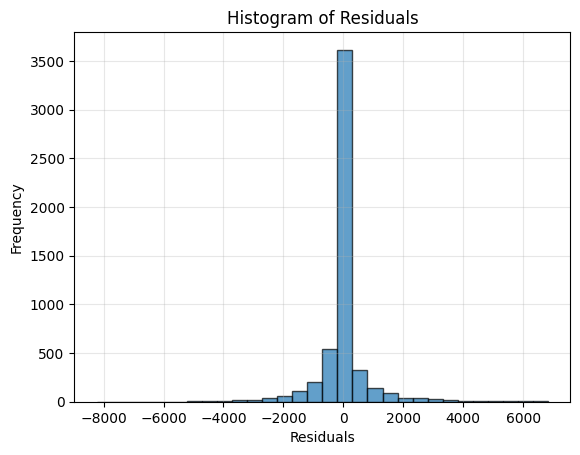

In [64]:
plt.hist(residual_test['Residuals'], bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.grid(alpha=0.3)
plt.show()

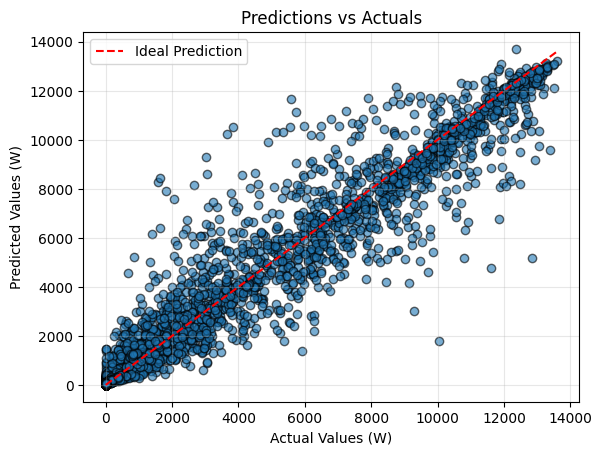

In [65]:

plt.scatter(test_results['Actuals'], test_results['Predictions'], alpha=0.6, edgecolor='k')
plt.plot([min(test_results['Actuals']), max(test_results['Actuals'])],
         [min(test_results['Actuals']), max(test_results['Actuals'])],
         color='r', linestyle='--', label='Ideal Prediction')
plt.xlabel('Actual Values (W)')
plt.ylabel('Predicted Values (W)')
plt.title('Predictions vs Actuals')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

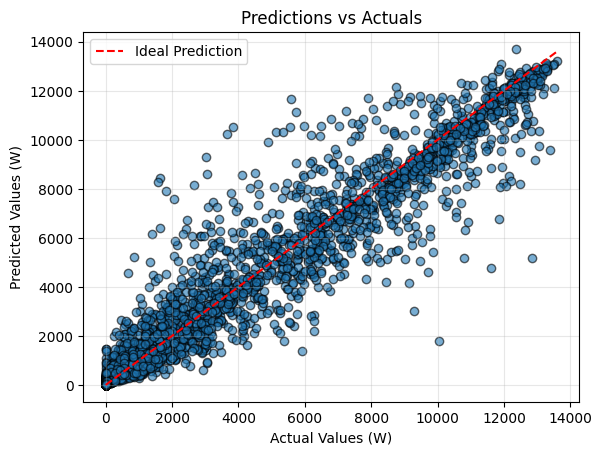

In [66]:
actuals = test_results['Actuals'].values.flatten()
predictions = test_results['Predictions'].values.flatten()


# Randomly sample 6000 points
sample_size = min(6000, len(actuals))

sample_indices = np.random.choice(len(actuals), sample_size, replace=False)
actuals_sampled = actuals[sample_indices]
predictions_sampled = predictions[sample_indices]

plt.scatter(actuals_sampled, predictions_sampled, alpha=0.6, edgecolor='k')
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)],
         color='r', linestyle='--', label='Ideal Prediction')

plt.xlabel('Actual Values (W)')
plt.ylabel('Predicted Values (W)')
plt.title('Predictions vs Actuals')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

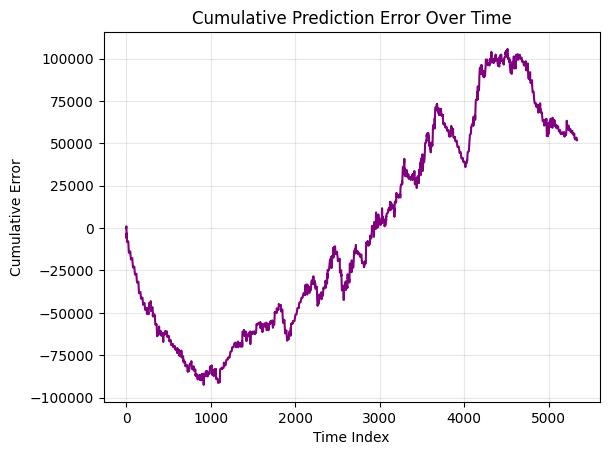

In [67]:

residual_cumsum = residual_test['Residuals'].cumsum()
plt.plot(residual_cumsum, color='purple')
plt.xlabel('Time Index')
plt.ylabel('Cumulative Error')
plt.title('Cumulative Prediction Error Over Time')
plt.grid(alpha=0.3)
plt.show()

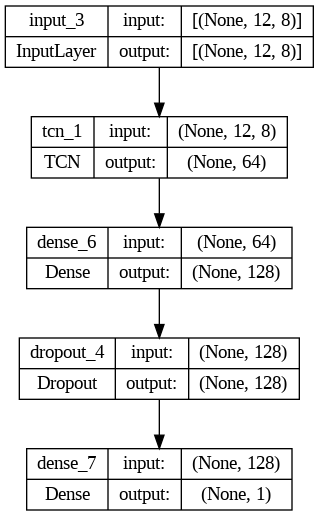

In [68]:
plot_model(tcn_model, show_shapes=True, show_layer_names=True, to_file='model_architecture.png')